2025-06-11 10:55:16,027 | INFO    | Stage 16 run folder: outputs_rff\event=2008\20250609
2025-06-11 10:55:22,550 | INFO    | High n=282 | Low n=246


,sectorname,rgroup,count,median,mean
0,Basic Materials,High,16,0.8151,0.8160
1,Basic Materials,Low,152,0.6393,0.6353
2,Basic Materials,Mid,133,0.7272,0.7328
3,Communication Services,High,8,0.8339,0.8331
4,Communication Services,Low,4,0.6781,0.6744
5,Communication Services,Mid,9,0.7279,0.7326
6,Consumer Cyclical,High,13,0.8157,0.8206
7,Consumer Cyclical,Low,3,0.6884,0.6779
8,Consumer Cyclical,Mid,25,0.7397,0.7488
9,Consumer Defensive,High,11,0.8240,0.8252


C:\Users\Jason Pohl\AppData\Local\Temp\ipykernel_34536\2033207266.py:150: RuntimeWarning: invalid value encountered in scalar divide
  d = (hi.mean()-lo.mean()) / np.sqrt((hi.var()+lo.var())/2)
C:\Users\Jason Pohl\AppData\Local\Temp\ipykernel_34536\2033207266.py:150: RuntimeWarning: invalid value encountered in scalar subtract
  d = (hi.mean()-lo.mean()) / np.sqrt((hi.var()+lo.var())/2)
C:\Users\Jason Pohl\AppData\Local\Temp\ipykernel_34536\2033207266.py:150: RuntimeWarning: invalid value encountered in scalar subtract
  d = (hi.mean()-lo.mean()) / np.sqrt((hi.var()+lo.var())/2)
C:\Users\Jason Pohl\AppData\Local\Temp\ipykernel_34536\2033207266.py:150: RuntimeWarning: invalid value encountered in scalar subtract
  d = (hi.mean()-lo.mean()) / np.sqrt((hi.var()+lo.var())/2)
C:\Users\Jason Pohl\AppData\Local\Temp\ipykernel_34536\2033207266.py:150: RuntimeWarning: invalid value encountered in scalar divide
  d = (hi.mean()-lo.mean()) / np.sqrt((hi.var()+lo.var())/2)
C:\Users\Jason Pohl\AppD

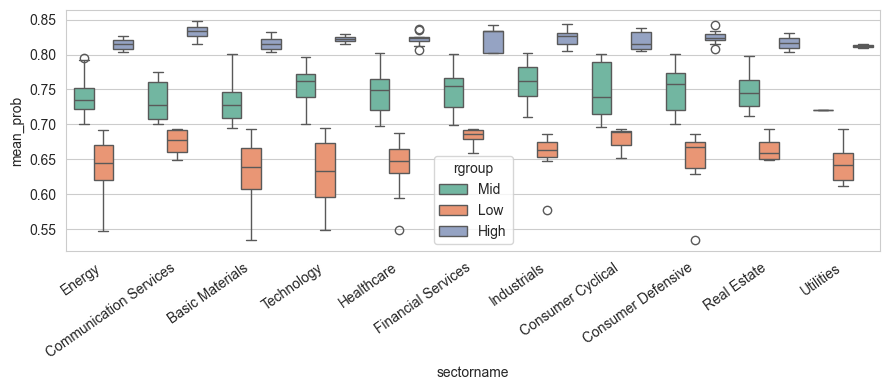

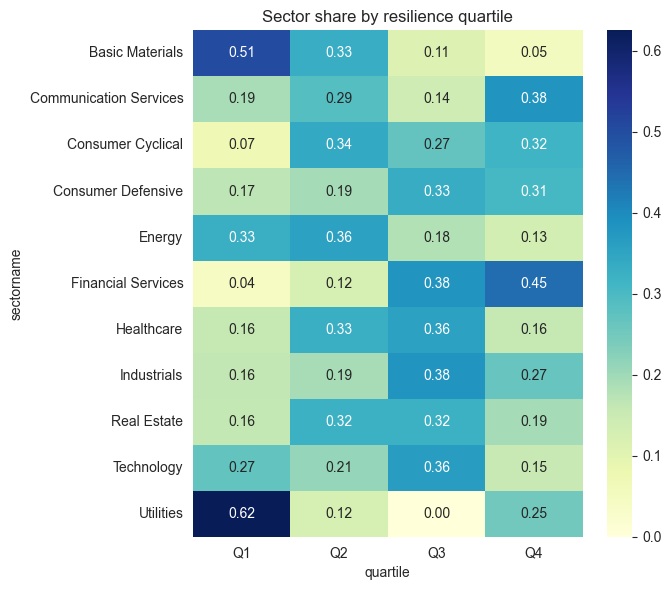

2025-06-11 10:55:25,160 | INFO    | ✓ Stage 16 complete – artefacts in outputs_rff\event=2008\20250609\stage16


In [1]:
#!/usr/bin/env python
# ======================================================================
#  STAGE 16 · HIGH vs LOW RESILIENCE – deep-dive comparatives   (v2)
# ======================================================================

from __future__ import annotations
import os, re, logging
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import ttest_ind, friedmanchisquare
import statsmodels.api as sm

logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s | %(levelname)-7s | %(message)s")
log = logging.getLogger("stage16")

# ── ENV CONFIG ──────────────────────────────────────────────────────
SWAN_YEAR   = int(os.getenv("SWAN_YEAR", 2008))
SNAP_YEAR   = SWAN_YEAR - 1                 #  t-1 snapshot (was 2007)
OUTPUT_ROOT = Path(os.getenv("OUTPUT_ROOT", "outputs_rff")).expanduser()

ID_COL      = os.getenv("ID_COL",      "Symbol").lower()
DATE_COL    = os.getenv("DATE_COL",    "ReportDate").lower()
SECTOR_COL  = os.getenv("SECTOR_COL",  "SectorName").lower()
HI_PCT      = float(os.getenv("HI_PCT", 0.25))      # top/bottom quantile
PLOT        = os.getenv("PLOT", "1") == "1"

# ── LOCATE RUN FOLDER ───────────────────────────────────────────────
def _env_path(var: str) -> Path | None:
    v = os.getenv(var)
    if v:
        p = Path(v).expanduser()
        if not p.exists():
            raise FileNotFoundError(f"{var}='{p}' not found")
        return p
    return None

if _env_path("RUN_DIR"):
    RUN_DIR = _env_path("RUN_DIR")           # type: ignore
else:
    event_dir = OUTPUT_ROOT / f"event={SWAN_YEAR}"
    cand = sorted(event_dir.glob("*/stage15/master_summary/KeyFindings.csv"),
                  key=lambda p: p.stat().st_mtime, reverse=True)
    if not cand:
        raise RuntimeError("Pipeline up to Stage 15 not found – run earlier stages.")
    RUN_DIR = cand[0].parents[2]

STAGE_DIR = RUN_DIR / "stage16"
STAGE_DIR.mkdir(parents=True, exist_ok=True)
log.info("Stage 16 run folder: %s", RUN_DIR)

# ── RESOLVE INPUT FILES ─────────────────────────────────────────────
def _need(canonical: Path, kw: list[str]) -> Path:
    if canonical.is_file():
        return canonical
    for fp in canonical.parent.glob("*.csv"):
        if all(k in fp.name.lower() for k in kw):
            return fp
    raise FileNotFoundError(f"Cannot find file with keywords {kw} in {canonical.parent}")

prob_csv  = _need(RUN_DIR / "stage11" / "Stage11_RISE_Probabilities_All.csv",
                  ["rise","prob"])
st3_csv   = RUN_DIR / "stage03" / "Stage3_Data_WithRatios.csv"
pca_csv   = RUN_DIR / "stage12" / "Stage12B_PCA_Scores.csv"

# ── LOAD & PREP DATA ────────────────────────────────────────────────
def _ld(fp: Path, dates=False) -> pd.DataFrame:
    df = pd.read_csv(fp, low_memory=False)
    df.columns = df.columns.str.lower().str.strip()
    if dates and DATE_COL in df.columns:
        df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    return df

prob  = _ld(prob_csv, dates=True)
stage3 = _ld(st3_csv, dates=True)

prob_cols = [c for c in prob.columns if "prob" in c]
prob["mean_prob"] = prob[prob_cols].mean(axis=1, skipna=True)
prob["year"] = prob[DATE_COL].dt.year

snap = prob[(prob["year"] == SNAP_YEAR) & prob["mean_prob"].notna()].copy()

if SECTOR_COL not in snap.columns:
    snap = snap.merge(stage3[[ID_COL, SECTOR_COL]].drop_duplicates(),
                      on=ID_COL, how="left")

# ── DEFINE HIGH / LOW GROUPS ────────────────────────────────────────
q_hi = snap["mean_prob"].quantile(1-HI_PCT)
q_lo = snap["mean_prob"].quantile(HI_PCT)

snap["rgroup"] = np.select(
    [snap["mean_prob"] >= q_hi, snap["mean_prob"] <= q_lo],
    ["High", "Low"], default="Mid"
)
hi_df, low_df = snap[snap.rgroup=="High"], snap[snap.rgroup=="Low"]
log.info("High n=%d | Low n=%d", len(hi_df), len(low_df))

# ── SECTOR SPLIT TABLE ──────────────────────────────────────────────
sector_tbl = (snap.groupby([SECTOR_COL, "rgroup"])["mean_prob"]
                 .agg(count="size", median="median", mean="mean")
                 .round(4).reset_index())
sector_tbl.to_csv(STAGE_DIR / "Stage16_SectorHighLow_Table.csv", index=False)
display(sector_tbl.head(12))

# ── WELCH t-tests on selected ratios ───────────────────────────────
want_patterns = {
    "totaldebt_totalassets": r"total\s*debt.*total\s*assets",
    "ebitda_margin"        : r"\bebitda\b.*margin",
    "roe"                  : r"\broe\b|return.*equity",
    "roa"                  : r"\broa\b|return.*assets"
}

st3_yr = stage3[stage3[DATE_COL].dt.year == SNAP_YEAR]
ratio_map: dict[str,str] = {}
for logical, pat in want_patterns.items():
    hits = [c for c in st3_yr.columns if re.search(pat, c)]
    if hits: ratio_map[logical] = hits[0]

merged = snap[[ID_COL, "rgroup"]].merge(
            st3_yr[[ID_COL] + list(ratio_map.values())], on=ID_COL, how="left")

tt_rows = []
for logical, col in ratio_map.items():
    hi = merged.loc[merged.rgroup=="High", col].astype(float).dropna()
    lo = merged.loc[merged.rgroup=="Low",  col].astype(float).dropna()
    if len(hi) < 30 or len(lo) < 30: continue
    t, p = ttest_ind(hi, lo, equal_var=False)
    d = (hi.mean()-lo.mean()) / np.sqrt((hi.var()+lo.var())/2)
    tt_rows.append({"Ratio":logical,"High_mean":hi.mean(),"Low_mean":lo.mean(),
                    "d_effect":d,"t_stat":t,"p_value":p})
pd.DataFrame(tt_rows).round(4).to_csv(
    STAGE_DIR / "Stage16_HighLow_Ttests.csv", index=False)

# ── EFFECT-SIZE SCAN OVER ALL RATIOS ───────────────────────────────
ratio_cols = [c for c in st3_yr.columns if "_" in c and not c.endswith("_raw")
              and pd.api.types.is_numeric_dtype(st3_yr[c])]
full = snap[[ID_COL,"rgroup"]].merge(
            st3_yr[[ID_COL] + ratio_cols], on=ID_COL, how="left")

eff_rows = []
for c in ratio_cols:
    hi = full.loc[full.rgroup=="High", c].astype(float).dropna()
    lo = full.loc[full.rgroup=="Low",  c].astype(float).dropna()
    if len(hi) < 30 or len(lo) < 30: continue
    d = (hi.mean()-lo.mean()) / np.sqrt((hi.var()+lo.var())/2)
    if abs(d) >= .30:
        eff_rows.append({"Ratio":c,"d_effect":round(d,3),
                         "High_mean":hi.mean(),"Low_mean":lo.mean()})
(pd.DataFrame(eff_rows)
   .sort_values("d_effect", key=np.abs, ascending=False)
   .to_csv(STAGE_DIR / "Stage16_EffectSizes_HighLow.csv", index=False))

# ── PLOTS ───────────────────────────────────────────────────────────
sns.set_style("whitegrid")
if PLOT:
    # Box-by-sector (top-12)
    top_secs = snap[SECTOR_COL].value_counts().head(12).index
    fig_box = plt.figure(figsize=(9,4))
    sns.boxplot(x=SECTOR_COL, y="mean_prob",
                hue="rgroup", palette="Set2",
                data=snap[snap[SECTOR_COL].isin(top_secs)])
    plt.xticks(rotation=35, ha="right"); plt.tight_layout()
    fig_box.savefig(STAGE_DIR / "Stage16_Box_Sector_HighLow.png", dpi=110)
    display(fig_box)
    plt.close(fig_box)

    # Quartile heat-map
    snap["quartile"] = pd.qcut(snap["mean_prob"], 4, labels=["Q1","Q2","Q3","Q4"])
    heat = (snap.pivot_table(index=SECTOR_COL, columns="quartile",
                             values="mean_prob", aggfunc="count").fillna(0))
    heat = (heat.T / heat.sum(axis=1)).T.round(3)
    fig_heat = plt.figure(figsize=(7,6))
    sns.heatmap(heat, cmap="YlGnBu", annot=True, fmt=".2f")
    plt.title("Sector share by resilience quartile"); plt.tight_layout()
    fig_heat.savefig(STAGE_DIR / "Stage16_Heat_SectorQuartileShare.png", dpi=110)
    display(fig_heat)
    plt.close(fig_heat)

    # PCA biplot if PCs exist
    if pca_csv.is_file():
        pcs = pd.read_csv(pca_csv)
        pcs.columns = pcs.columns.str.lower().str.strip()
        pc_cols = [c for c in pcs.columns if c.startswith("pc")]
        if len(pc_cols) >= 2:
            plot_df = pcs.merge(snap[[ID_COL,"rgroup"]], on=ID_COL, how="left")
            fig_pca = plt.figure(figsize=(6,4))
            sns.scatterplot(x=pc_cols[0], y=pc_cols[1],
                            hue="rgroup", palette="Set1",
                            data=plot_df, s=40, alpha=.75,
                            edgecolor="k", linewidth=.3)
            plt.title(f"PCA (PC1 vs PC2) – {SNAP_YEAR}")
            plt.tight_layout()
            fig_pca.savefig(STAGE_DIR / "Stage16_Biplot_PCA_HighLow.png", dpi=110)
            display(fig_pca)
            plt.close(fig_pca)

log.info("✓ Stage 16 complete – artefacts in %s", STAGE_DIR)
